In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.LUG_GINOT import LoadModel
from models import configs
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import pyvista as pv
import json
import os
from IPython.display import HTML, display_html
device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
# TODO: change backend to "html" for higher resolution and interactive plots
pv_bc="static" # "static", "html", "client"
pv.set_jupyter_backend(pv_bc)
# pv.global_theme.trame.jupyter_extension_enabled = True
# pv.global_theme.trame.server_proxy_enabled = True
if pv_bc == "static":
  window_size = (1280*2, 600*2)
else:
  window_size = (1024, 256)
show_edges=True

In [3]:
configs_jeb = configs.LUG_GINOT_configs()

filebase = configs_jeb["filebase"]
trunk_args = configs_jeb["trunk_args"]
branch_args = configs_jeb["branch_args"]
jeb_ginot = LoadModel(filebase, branch_args, trunk_args)
print("filebase: ", filebase)
print("trunk_args: ", trunk_args)
print("branch_args: ", branch_args)


Total number of parameters of Geo encoder: 690689, 690689 of which are trainable
Total number of parameters of NOT model: 2116738, 2116738 of which are trainable
filebase:  /work/hdd/bdsy/qibang/repository_Wbdsy/GINOT/models/saved_weights/LUG_GINOT_test
trunk_args:  {'embed_dim': 128, 'cross_attn_layers': 3, 'num_heads': 8, 'dropout': 0.0, 'padding_value': -1000}
branch_args:  {'input_channels': 3, 'out_c': 128, 'latent_d': None, 'width': 128, 'n_point': 512, 'n_sample': 64, 'radius': 0.5, 'd_hidden': [128, 128], 'num_heads': 8, 'cross_attn_layers': 1, 'self_attn_layers': 2, 'fps_method': 'fps', 'pc_padding_val': -1000, 'dropout': 0.0}


In [4]:
train_dataloader, test_dataloader, cells_all, s_inverse, pc_inverse, vert_inverse = configs.LoadDataLUGGeo(
    bs_train=64, bs_test=64, shuffle_loader=False)



Data loading time: 10.52 s


In [5]:


def predict(data_loader, ginot):
    y_pred = []
    y_true = []
    verts_all = []
    pc_all = []
    sample_ids = np.empty(0, dtype=int)
    ginot.eval()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Predicting"):
            load = data[0].to(device) # (B,1)
            pc = data[1].to(device)  # (B, N, 3)
            xyt = data[2].to(device)  # (B, N, 3)
            y_true_batch = data[3].to(device)  # (B, N)
            mask = (y_true_batch != ginot.padding_value)
            pred = ginot(load,xyt, pc)
            pred = s_inverse(pred)
            y_true_batch = s_inverse(y_true_batch)
            pred = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                    for x, i in zip(pred, mask)]
            y_true_batch = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                            for x, i in zip(y_true_batch, mask)]
            y_pred = y_pred+pred
            y_true = y_true+y_true_batch

            mask_verts = (xyt != configs.PADDING_VALUE).cpu().detach().numpy()
            verts_inv = vert_inverse(xyt)
            verts_all = verts_all+[x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                                   for x, i in zip(verts_inv, mask_verts)]

            mask_pc = (pc != configs.PADDING_VALUE).cpu().detach().numpy()
            pc_inv = pc_inverse(pc)
            pc_all = pc_all+[x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                             for x, i in zip(pc_inv, mask_pc)]
            sample_ids = np.append(sample_ids, data[4].cpu().detach().numpy())

    return y_pred, y_true, verts_all, pc_all, sample_ids


def plot_results(pc, u_true, u_pred, cells, verts,
                 label="Mises stress [MPa]", opacity=1.0,
                 pc_color='green', point_size=5.0, cmap="viridis",
                 notebook=None, show_edges=True,
                 html_file=None, window_size=(1024, 256)):
    cell_types = np.full(len(cells), pv.CellType.HEXAHEDRON)
    mesh_t = pv.UnstructuredGrid(cells.flatten(), cell_types, verts)
    mesh_p = pv.UnstructuredGrid(cells.flatten(), cell_types, verts)
    mesh_e = pv.UnstructuredGrid(cells.flatten(), cell_types, verts)
    true_label = "True "+label
    pred_label = "Pred. "+label
    error_label = "Abs. error [MPa]"
    mesh_t.point_data[true_label] = u_true
    mesh_p.point_data[pred_label] = u_pred
    mesh_e.point_data[error_label] = np.abs(u_pred-u_true)
    plotter = pv.Plotter(shape=(1, 4), notebook=notebook,
                         window_size=window_size)
    # pc mesh
    plotter.subplot(0, 0)
    pc_mesh = pv.PolyData(pc)
    # plotter.reset_camera()
    plotter.add_mesh(pc_mesh, color=pc_color, point_size=point_size)
    plotter.subplot(0, 1)
    plotter.add_mesh(mesh_t, scalars=true_label,
                     show_edges=show_edges, opacity=opacity, cmap=cmap, clim=[np.min(u_true), np.max(u_true)])

    # plotter.reset_camera()
    plotter.subplot(0, 2)
    plotter.add_mesh(mesh_p, scalars=pred_label,
                     show_edges=show_edges, opacity=opacity,
                     cmap=cmap, clim=[np.min(u_true), np.max(u_true)])  #
    plotter.subplot(0, 3)
    plotter.add_mesh(mesh_e, scalars=error_label,
                     show_edges=show_edges, opacity=opacity,
                     cmap=cmap)  #, clim=[0, np.max(u_true)]
    # plotter.reset_camera()
    if html_file is not None:
        plotter.export_html(html_file)
    else:
        plotter.show()


def cal_l2_error(y_pred, y_true):

    error_s = []
    for y_p, y_t in zip(y_pred, y_true):
        s_p, s_t = y_p[:], y_t[:]
        e_s = np.linalg.norm(s_p-s_t)/np.linalg.norm(s_t)
        error_s.append(e_s)
    error_s = np.array(error_s)
    return error_s


def load_html(file_path):
    # Open and read the HTML file
    with open(file_path, 'r') as file:
        html_content = file.read()
    html_content = f"""
    <div style="width: 100%; height: 600px; ">
        {html_content}
    </div>
    """
    # HTML(html_content) overflow:auto;
    return html_content



In [6]:
# test data
time_start = time.time()
s_pred_test, s_true_test, verts_all_test, pc_all_test, sample_ids_test = predict(
    test_dataloader, jeb_ginot)
time_end = time.time()
print(f"Time taken to predict all samples: {time_end-time_start:.2e} seconds")
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred_test):.2e} seconds")



Predicting: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]

Time taken to predict all samples: 1.01e+01 seconds
Time taken to predict one sample: 1.69e-02 seconds


Mean L2 error of stress of test dataset: 0.0045142811723053455, std: 0.0023119498509913683


Text(0, 0.5, 'Frequency')

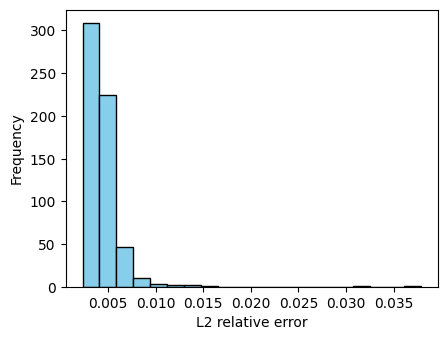

In [7]:
error_s = cal_l2_error(s_pred_test, s_true_test)
mean, std = np.mean(error_s), np.std(error_s)
print(f"Mean L2 error of stress of test dataset: {mean}, std: {std}")
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)
_ = ax.hist(error_s, bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")


L2 realtive error: 0.002344342414289713


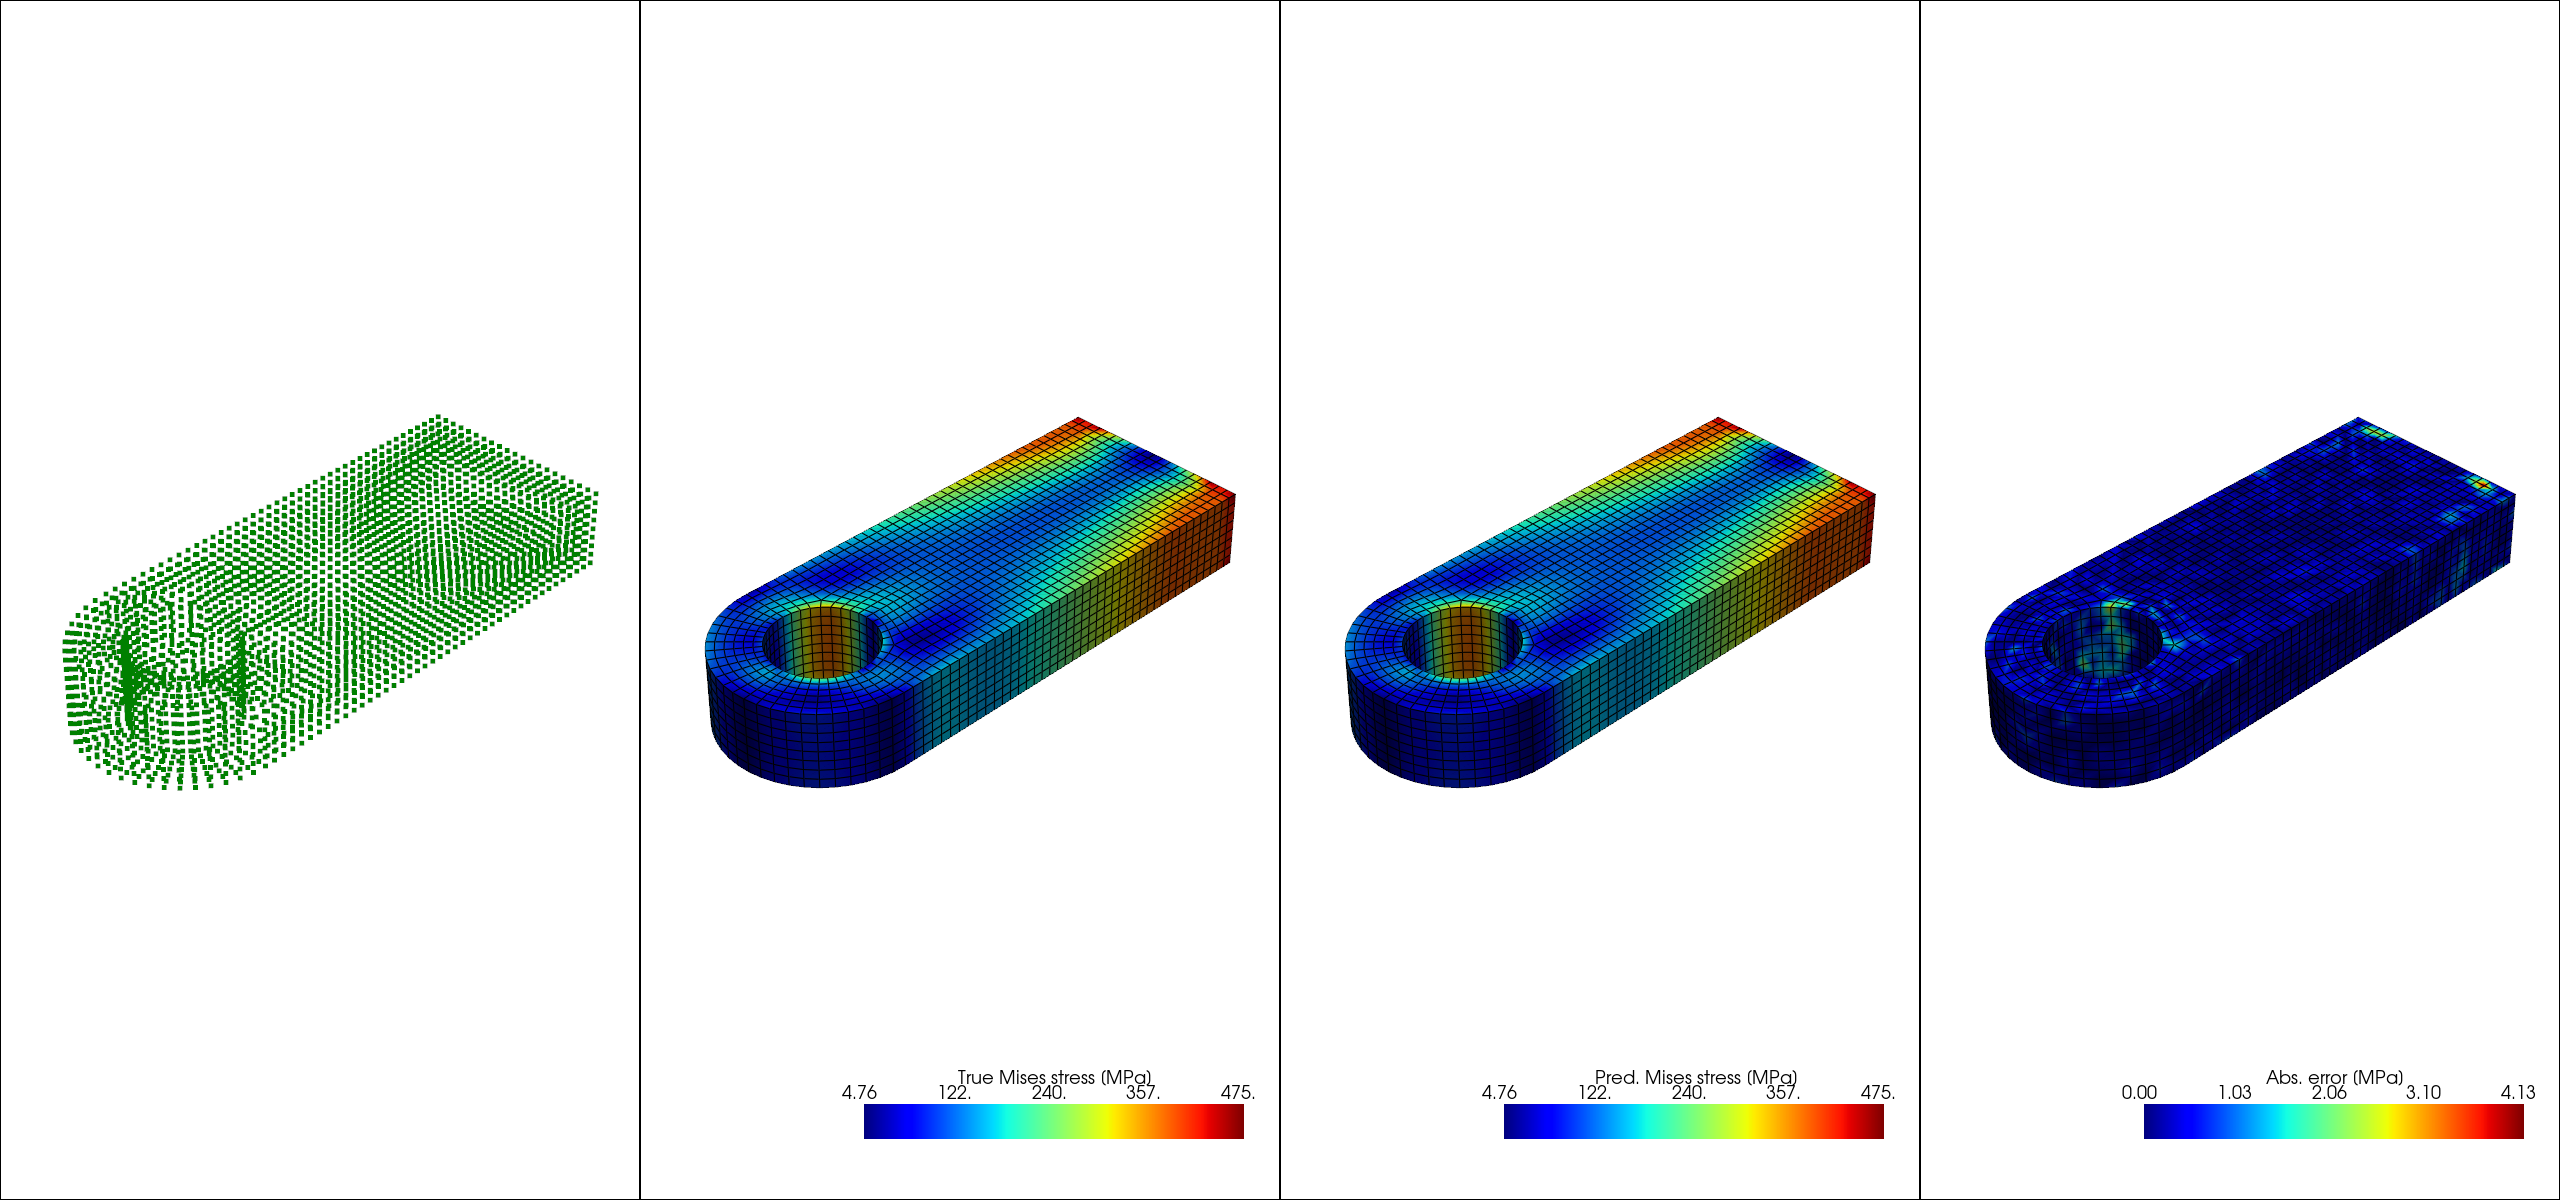

In [8]:
# plot the best test sample
sort_idx = np.argsort(error_s)
median_index = sort_idx[0]
print(f"L2 realtive error: {error_s[median_index]}")
cells_test = cells_all[sample_ids_test[median_index]]
verts_test = verts_all_test[median_index]
surface_pc_test = pc_all_test[median_index]
True_s_test = s_true_test[median_index]
Pred_s_test = s_pred_test[median_index]
plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True,show_edges=show_edges, html_file=None, window_size=window_size)
# plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
#              verts_test, cmap="jet", notebook=True,show_edges=False, html_file=None)

L2 realtive error: 0.004070124123245478


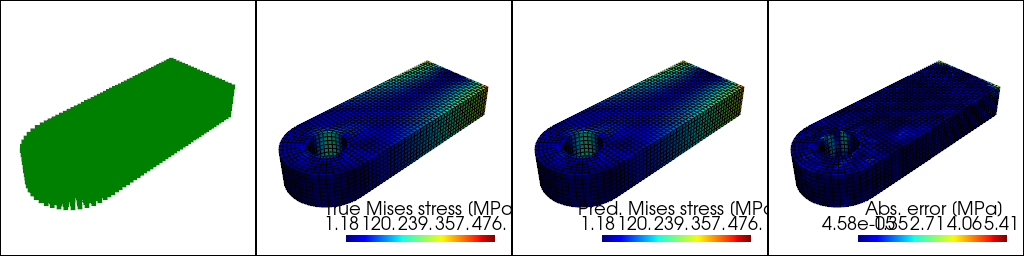

In [9]:
# plot the median sample
sort_idx = np.argsort(error_s)
median_index = sort_idx[int(len(sort_idx) * 0.5)-1]
print(f"L2 realtive error: {error_s[median_index]}")
cells_test = cells_all[sample_ids_test[median_index]]
verts_test = verts_all_test[median_index]
surface_pc_test = pc_all_test[median_index]
True_s_test = s_true_test[median_index]
Pred_s_test = s_pred_test[median_index]
plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True,show_edges=show_edges, html_file=None)



L2 realtive error: 0.0378338098526001


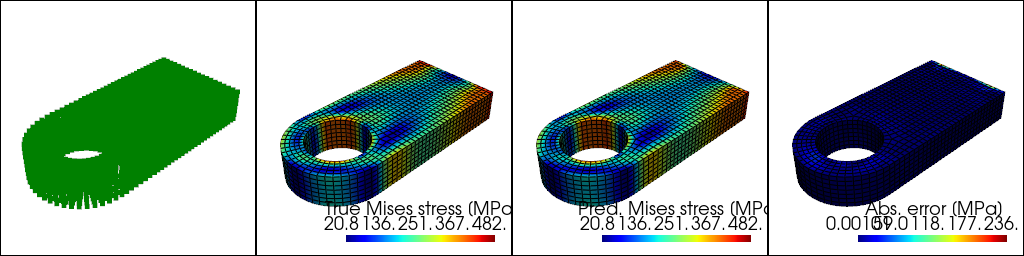

In [10]:
# plot the worst test sample
sort_idx = np.argsort(error_s)
median_index = sort_idx[int(len(sort_idx))-1]
print(f"L2 realtive error: {error_s[median_index]}")
cells_test = cells_all[sample_ids_test[median_index]]
verts_test = verts_all_test[median_index]
surface_pc_test = pc_all_test[median_index]
True_s_test = s_true_test[median_index]
Pred_s_test = s_pred_test[median_index]
plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True,show_edges=show_edges, html_file=None)
# plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
#              verts_test, cmap="jet", notebook=True,show_edges=False, html_file=None)

In [11]:
# Training data
time_start = time.time()
s_pred_train, s_true_train, verts_all_train, pc_all_train, sample_ids_train = predict(
    train_dataloader, jeb_ginot)
time_end = time.time()
print(f"Time taken to predict all samples: {time_end-time_start:.2e} seconds")
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred_train):.2e} seconds")



Predicting: 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]

Time taken to predict all samples: 3.25e+01 seconds
Time taken to predict one sample: 1.35e-02 seconds


Mean L2 error of stress of training dataset: 0.0037800518330186605, std: 0.0008596200495958328


Text(0, 0.5, 'Frequency')

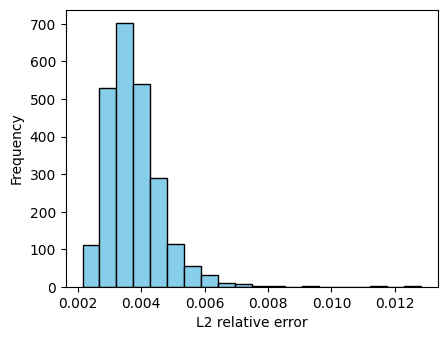

In [12]:
error_s = cal_l2_error(s_pred_train, s_true_train)
mean, std = np.mean(error_s), np.std(error_s)
print(f"Mean L2 error of stress of training dataset: {mean}, std: {std}")
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)
_ = ax.hist(error_s, bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")


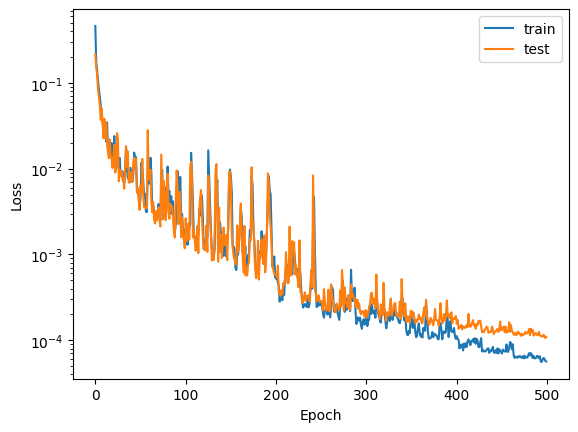

In [13]:
loss_file = filebase + "/logs.json"
with open(loss_file, 'r') as f:
    data = json.load(f)
plt.plot(data['loss'], label='train')
plt.plot(data['val_loss'], label='test')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


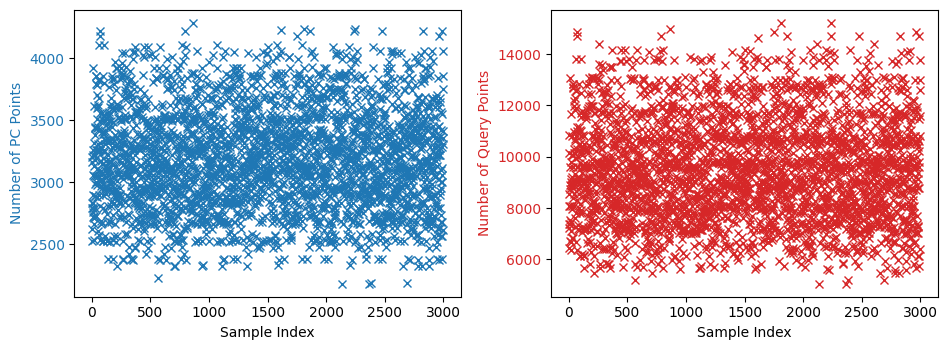

In [14]:
num_pc_point = [len(x) for x in pc_all_train]+[len(x) for x in pc_all_test]
num_query_points = [len(x) for x in verts_all_train] + \
    [len(x) for x in verts_all_test]

fig = plt.figure(figsize=(4.8*2, 3.6))
ax1 = plt.subplot(1, 2, 1)
color = 'tab:blue'
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Number of PC Points', color=color)
ax1.plot(num_pc_point, 'x', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = plt.subplot(1, 2, 2)
color = 'tab:red'
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Number of Query Points', color=color)
ax2.plot(num_query_points, 'x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

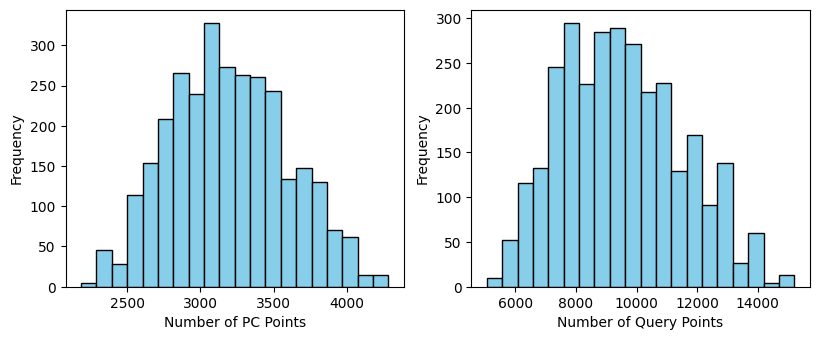

In [15]:
num_pc_point = [len(x) for x in pc_all_train]+[len(x) for x in pc_all_test]
num_query_points = [len(x) for x in verts_all_train] + \
    [len(x) for x in verts_all_test]

fig = plt.figure(figsize=(4.8*2, 3.6))
ax = plt.subplot(1, 2, 1)
_ = ax.hist(num_pc_point, bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("Number of PC Points")
ax.set_ylabel("Frequency")
ax = plt.subplot(1, 2, 2)
_ = ax.hist(num_query_points, bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("Number of Query Points")
ax.set_ylabel("Frequency")
